# 9.2 An Image Segmentation Example

In [ ]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar xf images.tar.gz
!tar xf annotations.tar.gz

--2025-06-14 16:02:02--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2025-06-14 16:02:02--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/pets/images.tar.gz [following]
--2025-06-14 16:02:03--  https://thor.robots.ox.ac.uk/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [app

In [ ]:
import os

input_dir = 'images/'
target_dir = 'annotations/trimaps'

input_image_paths = sorted([
    os.path.join(input_dir, fname)
    for fname in os.listdir(input_dir)
    if fname.endswith(".jpg")
    ]
)

target_paths = sorted([
    os.path.join(target_dir, fname)
    for fname in os.listdir(target_dir)
    if fname.endswith(".png") and not fname.startswith(".")
    ]
)

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

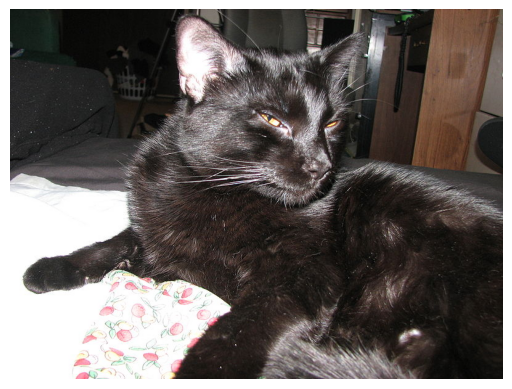

In [ ]:
plt.axis("off")
plt.imshow(load_img(input_image_paths[9]))
plt.imshow(load_img(input_image_paths[654]))

# Images are of different sizes, we have to set a uniform size for every image manually!

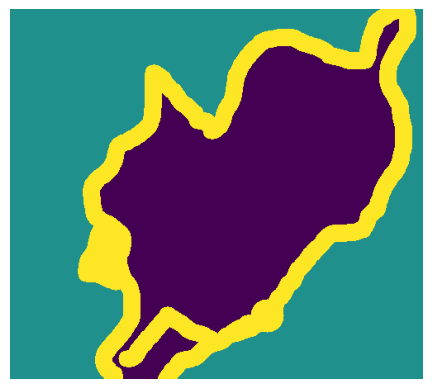

In [ ]:
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))
display_target(img)

In [ ]:
import numpy as np
import random

img_size = (200, 200)
num_imgs = len(input_image_paths)

random.Random(1337).shuffle(input_image_paths)
random.Random(1337).shuffle(target_paths)
# We are using the same seed, so that we end up with same indices in both arrays

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(load_img(path, target_size=img_size, color_mode='grayscale'))
    img = img.astype('uint8') - 1
    return img

# Pre-allocating a numpy array to load the images in memory
# The '+' symbol is used for concatenation here
# The final input size is (num_imgs, img_size, 3)
input_imgs = np.zeros((num_imgs, ) + img_size + (3, ), dtype='float32')
targets = np.zeros((num_imgs, ) + img_size + (1, ), dtype='uint8')

for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_image_paths[i])
    targets[i] = path_to_target(target_paths[i])

num_val_samples = 1000
train_input_imgs = input_imgs[: -num_val_samples]
train_targets = targets[: -num_val_samples]
val_input_imgs = input_imgs[-num_val_samples: ]
val_targets = targets[-num_val_samples: ]

In [ ]:
from tensorflow import keras
from keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3, ))
    x = layers.Rescaling(1./255)(inputs) # The rescaling step is very important so that our weights do not blow up

    x = layers.Conv2D(filters=64, kernel_size=3, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=128, kernel_size=3, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=256, kernel_size=3, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same')(x)

    x = layers.Conv2DTranspose(filters=256, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(filters=256, kernel_size=3, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(filters=64, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, activation='relu', padding='same')(x)

    outputs = layers.Conv2D(filters=num_classes, kernel_size=3, activation='softmax', padding='same')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 25, 25, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 50, 50, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 50, 50, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 100, 100, 128)  │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 100, 100, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 200, 200, 64)   │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 200, 200, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,880,643 (10.99 MB)

 Trainable params: 2,880,643 (10.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy'
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='oxford_segmentation.keras',
        save_best_only=True
    )
]

history = model.fit(
    train_input_imgs, train_targets,
    epochs=50,
    callbacks=callbacks,
    validation_data=(val_input_imgs, val_targets)
)

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 103s 396ms/step - loss: 0.9562 - val_loss: 0.9083
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 95s 271ms/step - loss: 0.8405 - val_loss: 0.7840
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 82s 269ms/step - loss: 0.7980 - val_loss: 0.8959
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 82s 271ms/step - loss: 0.7627 - val_loss: 0.8694
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 53s 267ms/step - loss: 0.7450 - val_loss: 0.6893
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 85s 282ms/step - loss: 0.6952 - val_loss: 0.8412
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 80s 271ms/step - loss: 0.6653 - val_loss: 0.6128
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 84s 281ms/step - loss: 0.6188 - val_loss: 0.6029
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 80s 271ms/step - loss: 0.5973 - val_loss: 0.5559
Epoch 10/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 82s 271ms/step - loss: 0.5624 - val_loss: 0.5330
Epoch 11/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 53s 267ms/step - loss: 0.5462 - val_loss: 0.5000
Epoch 12/50
200/20

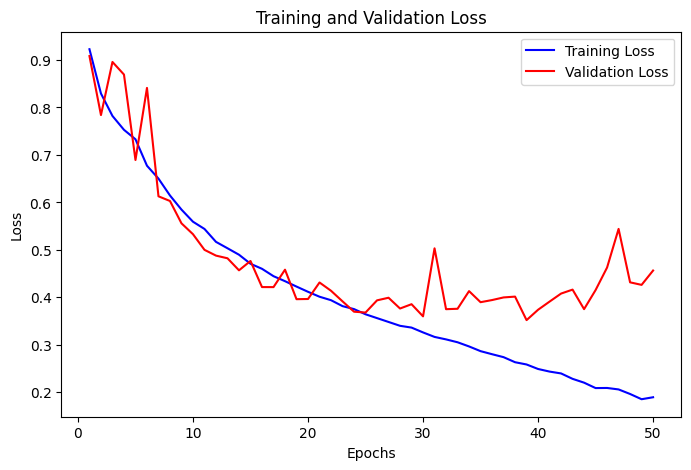

In [ ]:
epochs = range(1, len(history.history['loss']) + 1)
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

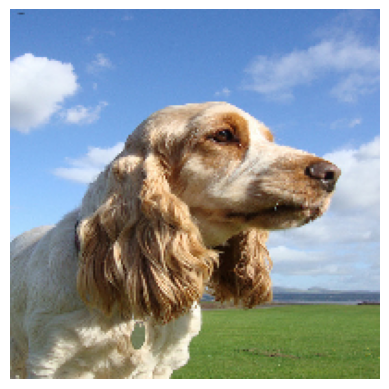

In [ ]:
from keras.utils import array_to_img

model = keras.models.load_model('oxford_segmentation.keras')

i = 500
test_img = val_input_imgs[i]
plt.axis('off')
plt.imshow(array_to_img(test_img))
# plt.clf()



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 818ms/step


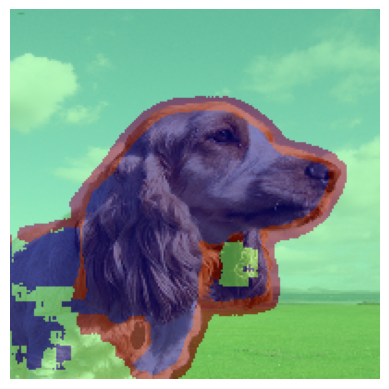

In [ ]:
mask = model.predict(np.expand_dims(test_img, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis('off')
    plt.imshow(array_to_img(test_img))
    plt.imshow(mask, cmap='jet', alpha=0.5)  # Overlay mask with transparency


display_mask(mask)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


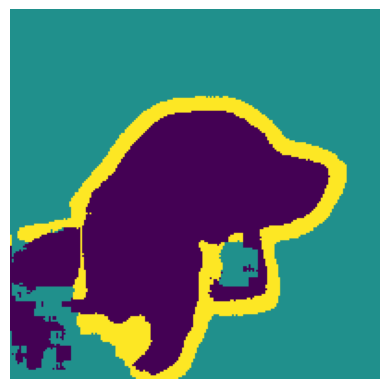

In [ ]:
mask = model.predict(np.expand_dims(test_img, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis('off')
    plt.imshow(mask)

display_mask(mask)

# 9.3 Moden Convnet Architecture Patterns

## Residual Connections

🔍 Hint: What do Residual Networks actually learn?

In a regular CNN:

    Each layer learns a full transformation.
    That is:        x → f(x)

In a Residual Network (ResNet):

    Each block learns a residual — a small correction to the input.
    That is:        x → f(x) + x

✅ This simple change makes training deep networks much easier:

   - Gradients flow more smoothly (no vanishing)
   - Early layers keep learning effectively
   - The model can refine features instead of relearning everything from scratch

In practice, we will implement a residual connection as follows.

    x = ...
    residual = x                    | A pointer to original input
    x = block(x)                    | This computation block can be destructive or noisy
    x = add([x, residual])          | Add the original input to the layer's output

In [1]:
from tensorflow import keras
from keras import layers

inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(inputs)
residual = x
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
residual = layers.Conv2D(filters=64, kernel_size=1)(residual)
x = layers.add([x, residual])

In [2]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(inputs)
residual = x
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(pool_size=2, padding='same')(x)
residual = layers.Conv2D(filters=64, kernel_size=1, strides=2)(residual)
x = layers.add([x, residual])

In [4]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Rescaling(1./255)(inputs)

def residual_block(x, num_filters, pooling=False):
    residual = x
    x = layers.Conv2D(filters=num_filters, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=num_filters, kernel_size=3, activation='relu', padding='same')(x)
    if pooling:
        x = layers.MaxPooling2D(pool_size=2, padding='same')(x)
        residual = layers.Conv2D(filters=num_filters, kernel_size=1, strides=2)(residual)
    elif num_filters != residual.shape[-1]:
        residual = layers.Conv2D(filters=num_filters, kernel_size=1)(residual)
    x = layers.add([x, residual])
    return x

x = residual_block(x, num_filters=32, pooling=True)
x = residual_block(x, num_filters=64, pooling=True)
x = residual_block(x, num_filters=128, pooling=False)

x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(units=1, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 32, 32, 3) │          0 │ input_layer_3[0]… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 32, 32,    │        896 │ rescaling_1[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 32, 32,    │      9,248 │ conv2d_14[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_15[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 16, 16,    │        128 │ rescaling_1[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 16, 16,    │          0 │ max_pooling2d_3[… │
│                     │ 32)               │            │ conv2d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 16, 16,    │     18,496 │ add_4[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 16, 16,    │     36,928 │ conv2d_17[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 8, 8, 64)  │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 8, 8, 64)  │      2,112 │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 8, 8, 64)  │          0 │ max_pooling2d_4[… │
│                     │                   │            │ conv2d_19[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 8, 8, 128) │     73,856 │ add_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 8, 8, 128) │    147,584 │ conv2d_20[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 8, 8, 128) │      8,320 │ add_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 8, 8, 128) │          0 │ conv2d_21[0][0],  │
│                     │                   │            │ conv2d_22[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ add_6[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │        129 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 297,697 (1.14 MB)

 Trainable params: 297,697 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

## Batch Normalization


    x = layers.Conv2D(32, 3, use_bias=False)(x)   
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

## Puttint it together: A mini Xception like model

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ujjwal2006","key":"e04b73006e798fe4105e8f5550ea7757"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats

 96% 782M/812M [00:06<00:00, 192MB/s]
100% 812M/812M [00:06<00:00, 125MB/s]


In [4]:
!unzip -qq dogs-vs-cats.zip

In [5]:
!unzip -qq train.zip

In [6]:
!rm -r cats_vs_dogs_small

rm: cannot remove 'cats_vs_dogs_small': No such file or directory


In [7]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
  for category in ("cat", "dog"):
    dir = new_base_dir / subset_name / category
    os.makedirs(dir)
    fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
    for fname in fnames:
      shutil.copyfile(src=original_dir / fname, dst=dir / fname)

make_subset("train", 0, 1000)
make_subset("validation", 1000, 1500)
make_subset("test", 1500, 2500)

In [8]:
from tensorflow import keras
from keras import layers

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
])

In [9]:

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(filters=size, kernel_size=3, padding='same', use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(filters=size, kernel_size=3, padding='same', use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    residual = layers.Conv2D(filters=size, kernel_size=1, strides=2, padding='same', use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(units=1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 180, 180,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 176, 176,  │      2,400 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 176, 176,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 176, 176,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 176, 176,  │      1,312 │ activation[0][0]  │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 176, 176,  │        128 │ separable_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 176, 176,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 176, 176,  │      1,312 │ activation_1[0][… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 88, 88,    │          0 │ separable_conv2d… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 88, 88,    │      1,024 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 88, 88,    │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 88, 88,    │        128 │ add[0][0]         │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 88, 88,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 88, 88,    │      2,336 │ activation_2[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 88, 88,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 88, 88,    │          0 │ batch_normalizat

 Total params: 721,857 (2.75 MB)

 Trainable params: 718,849 (2.74 MB)

 Non-trainable params: 3,008 (11.75 KB)

In [10]:
model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [11]:
from keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / 'train',
    image_size=(180, 180),
    batch_size=32
)
validation_dataset = image_dataset_from_directory(
    new_base_dir / 'validation',
    image_size=(180, 180),
    batch_size=32
)
test_dataset = image_dataset_from_directory(
    new_base_dir / 'test',
    image_size=(180, 180),
    batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [12]:
for data_batch, labels_batch in train_dataset:
  print(data_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [14]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.6959 - loss: 0.5932 - val_accuracy: 0.5000 - val_loss: 0.7647
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.6992 - loss: 0.5764 - val_accuracy: 0.5000 - val_loss: 0.8574
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.7311 - loss: 0.5508 - val_accuracy: 0.5000 - val_loss: 0.8906
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 0.7533 - loss: 0.5110 - val_accuracy: 0.5000 - val_loss: 1.1710
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.7807 - loss: 0.4562 - val_accuracy: 0.5000 - val_loss: 1.0716
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.7946 - loss: 0.4374 - val_accuracy: 0.5590 - val_loss: 0.9948
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - accuracy: 0.8244 - loss: 0.3945 - val_accuracy: 0.5190 - val_loss: 1.5875
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.8582 - loss: 0.3293 - val

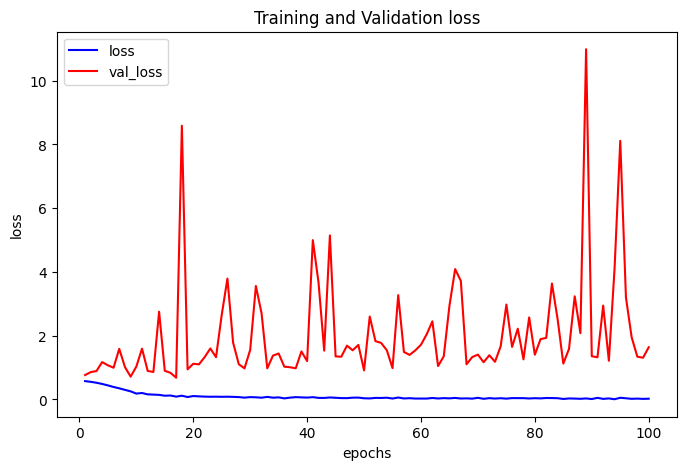

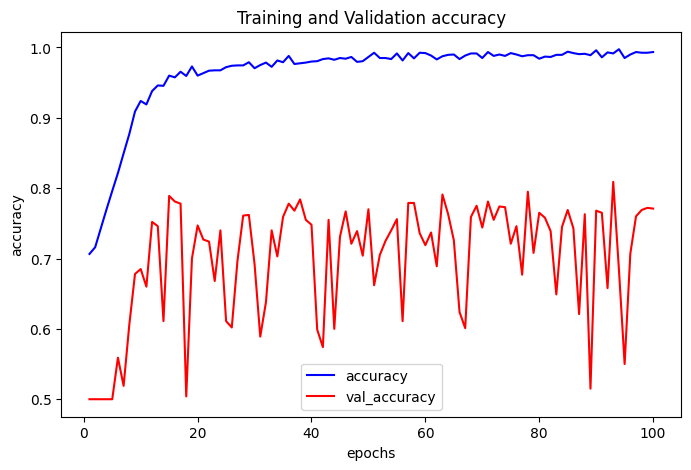

In [15]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, "b", label="loss")
plt.plot(epochs, val_loss, "r", label="val_loss")
plt.title("Training and Validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epochs, accuracy, "b", label="accuracy")
plt.plot(epochs, val_accuracy, "r", label="val_accuracy")
plt.title("Training and Validation accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [16]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_accuracy = test_model.evaluate(test_dataset)
print(test_accuracy)

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.7592 - loss: 0.8161
0.7645000219345093


# Interpreting what convnets learn

In [26]:
from tensorflow import keras

model = keras.models.load_model('convnet_from_scratch.keras')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 180, 180,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 176, 176,  │      2,400 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 176, 176,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 176, 176,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 176, 176,  │      1,312 │ activation[0][0]  │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 176, 176,  │        128 │ separable_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 176, 176,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 176, 176,  │      1,312 │ activation_1[0][… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 88, 88,    │          0 │ separable_conv2d… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 88, 88,    │      1,024 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 88, 88,    │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 88, 88,    │        128 │ add[0][0]         │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 88, 88,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 88, 88,    │      2,336 │ activation_2[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 88, 88,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 88, 88,    │          0 │ batch_normalizat

 Total params: 1,440,708 (5.50 MB)

 Trainable params: 718,849 (2.74 MB)

 Non-trainable params: 3,008 (11.75 KB)

 Optimizer params: 718,851 (2.74 MB)

80329/80329 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step


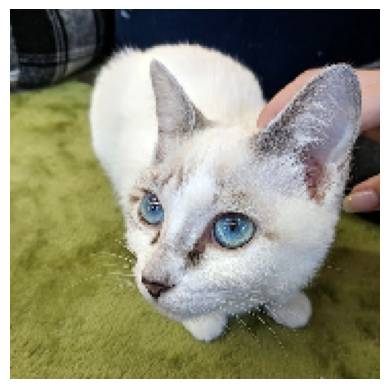

In [5]:
import numpy as np

img_path = keras.utils.get_file(
    fname='cat.jpg',
    origin='https://img-datasets.s3.amazonaws.com/cat.jpg'
)

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(
        img_path, target_size=target_size
    )
    array = keras.utils.img_to_array(img)
    # We have to convert a single image into a batch of one sample
    array = np.expand_dims(array, axis=0)
    return array

img_tensor = get_img_array(img_path, target_size=(180, 180))

import matplotlib.pyplot as plt
plt.axis('off')
plt.imshow(img_tensor[0].astype('uint8'))
plt.show()

In [9]:
from keras import layers

layer_outputs = []
layer_names = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)

activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(img_tensor)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


In [10]:
first_layer_activation = activations[0]
first_layer_activation.shape

(1, 176, 176, 32)

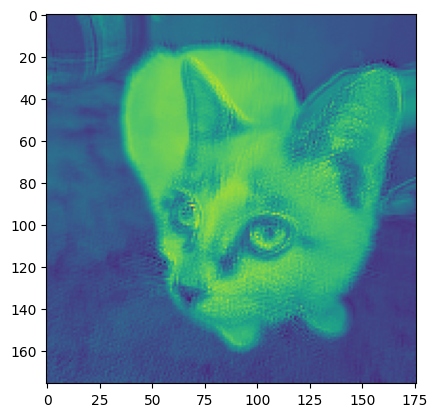

In [17]:
import matplotlib.pyplot as plt
plt.imshow(first_layer_activation[0, :, :, 10])
# this is what 10th channel in first layer's output looks like

In [22]:
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((size + 1) * n_cols - 1, images_per_row * (size + 1) - 1))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row  + row
            channel_image = layer_activation[0, :, :, channel_index].copy()
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128

            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[
                col * (size + 1) : (col + 1) * size + col,
                row * (size + 1) : (row + 1) * size + row
            ] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

Output hidden; open in https://colab.research.google.com to view.

## Visualizing Convnet Filters

In [27]:
model = keras.applications.xception.Xception(
    weights='imagenet',
    include_top=False
)

In [24]:
for layer in model.layers:
    if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
        print(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d
block3_sepconv1
block3_sepconv2
conv2d_1
block4_sepconv1
block4_sepconv2
conv2d_2
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_3
block14_sepconv1
block14_sepconv2


In [32]:
layer_name = 'block3_sepconv1'
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)
layer.output

<KerasTensor shape=(None, None, None, 256), dtype=float32, sparse=False, name=keras_tensor_361>

In [34]:
activation = feature_extractor(keras.applications.xception.preprocess_input(img_tensor))

In [35]:
import tensorflow as tf

# The loss function takes an image tensor and the index of the filter we are considering (an integer).
def compute_loss(image, filter_index):
    activation = feature_extractor(image)

    # we avoid border artifacts by only involving non-border pixels in the loss; we discard the first two pixels along the sides of the activation.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]

    return tf.reduce_mean(filter_activation)

@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image, filter_index)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return image

In [36]:
img_width = 200
img_height = 200

def generate_filter_pattern(filter_index):
    iterations = 30
    learning_rate = 10.
    image = tf.random.uniform(
        minval=0.4,
        maxval=0.5,
        shape=(1, img_width, img_height, 3)
    )
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate)
    return image[0].numpy()


 The resulting image tensor is a floating-point array of shape (200, 200, 3), with val
ues that may not be integers within [0, 255]. Hence, we need to post-process this ten
sor to turn it into a displayable image. We do so with the following straightforward
 utility function

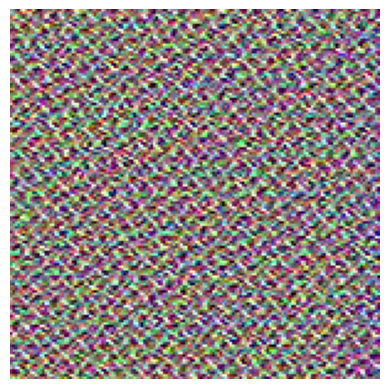

In [42]:
def deprocess_image(image):
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype('uint8')
    image = image[25:-25, 25:-25, :]
    return image

plt.axis('off')
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=0)))

In [43]:
all_images= []

for filter_index in range(64):
    print(f'processing filter {filter_index}')
    image = deprocess_image(generate_filter_pattern(filter_index=filter_index))
    all_images.append(image)

margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

for i in range(n):
    for j in range(n):
        image = all_images[i * n + j]
        row_start = (cropped_width + margin) * i
        row_end = (cropped_width + margin) * i + cropped_width
        column_start = (cropped_height + margin) * i
        column_end = (cropped_height + margin) * i + cropped_height

        stitched_filters[
            row_start: row_end,
            column_start: column_end,
            :] = image

keras.utils.save_img(f'filters_for_laer_{layer_name}.png', stitched_filters)

processing filter 0
processing filter 1
processing filter 2
processing filter 3
processing filter 4
processing filter 5
processing filter 6
processing filter 7
processing filter 8
processing filter 9
processing filter 10
processing filter 11
processing filter 12
processing filter 13
processing filter 14
processing filter 15
processing filter 16
processing filter 17
processing filter 18
processing filter 19
processing filter 20
processing filter 21
processing filter 22
processing filter 23
processing filter 24
processing filter 25
processing filter 26
processing filter 27
processing filter 28
processing filter 29
processing filter 30
processing filter 31
processing filter 32
processing filter 33
processing filter 34
processing filter 35
processing filter 36
processing filter 37
processing filter 38
processing filter 39
processing filter 40
processing filter 41
processing filter 42
processing filter 43
processing filter 44
processing filter 45
processing filter 46
processing filter 47
pr

## Visualizing heatmaps of class activation

In [44]:
model = keras.applications.xception.Xception(weights='imagenet')

91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [45]:
img_path = keras.utils.get_file(
    fname='elephant.jpg',
    origin='https://img-datasets.s3.amazonaws.com/elephant.jpg'
)


733657/733657 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [46]:
def get_img_array(image_path, target_size):
    img = keras.utils.load_img(image_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = keras.applications.xception.preprocess_input(array)
    return array

img_array = get_img_array(image_path=img_path, target_size=(299, 299))

In [47]:
preds = model.predict(img_array)
print(keras.applications.xception.decode_predictions(preds, top=3)[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
[('n02504458', 'African_elephant', np.float32(0.8699399)), ('n01871265', 'tusker', np.float32(0.0769561)), ('n02504013', 'Indian_elephant', np.float32(0.023541728))]


In [49]:
np.argmax(preds[0])

np.int64(386)

To visualize which parts of the image are the most African-elephant–like, let’s set up
 the Grad-CAM process.

  First, we create a model that maps the input image to the activations of the last
 convolutional layer

In [50]:
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions"
]

last_conv_layer = model.get_layer(name=last_conv_layer_name)
last_conv_layer_model = keras.Model(inputs=model.inputs, outputs=last_conv_layer.output)

 Second, we create a model that maps the activations of the last convolutional layer to
 the final class predictions

In [52]:
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(name=layer_name)(x)
classifier_model = keras.Model(inputs=classifier_input, outputs=x)



Now we compute the gradient of the top predicted class for our input image with respect to activations of the last convolution layer.

In [53]:
import tensorflow as tf

with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_474']
Received: inputs=Tensor(shape=(1, 299, 299, 3))
  warnings.warn(msg)


Now we apply maxpooling and importance weighting to the gradient tensor to obtain our heatmap of class activation.

In [54]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

heatmap = np.mean(last_conv_layer_output, axis=-1)

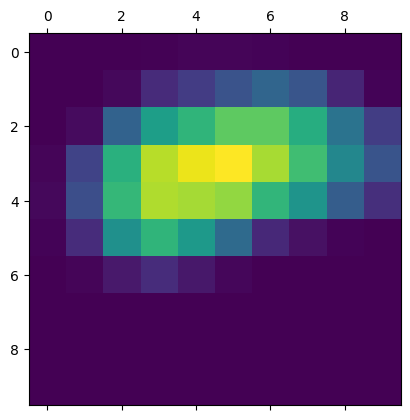

In [55]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)


Finally, let’s generate an image that superimposes the original image on the heatmap
 we just obtained (see figure 9.20).

In [58]:
import matplotlib.cm as cm

img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)
heatmap = np.uint8(255 * heatmap)

jet = cm.get_cmap('jet')
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

save_path = 'elephant_cam.jpg'
superimposed_img.save(save_path)

<ipython-input-58-944676894>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap('jet')
